In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import torch

from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from molexplain.utils import MODELS_PATH, PROCESSED_DATA_PATH

RDKit WARNING: [11:40:25] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
model = torch.load(os.path.join(MODELS_PATH, "AZ_ChEMBL.pt"))
inchis = np.load(os.path.join(PROCESSED_DATA_PATH, "inchis.npy"))

In [4]:
from rdkit.Chem import MolFromInchi

In [5]:
example_inchi = inchis[128]
print(example_inchi)

InChI=1S/C22H31ClN4O3/c1-15-10-20(26-27(15)13-17(28)12-24)16-6-7-19(23)18(11-16)21(29)25-14-22(30)8-4-2-3-5-9-22/h6-7,10-11,17,28,30H,2-5,8-9,12-14,24H2,1H3,(H,25,29)/t17-/m1/s1


In [6]:
mol = MolFromInchi(example_inchi)

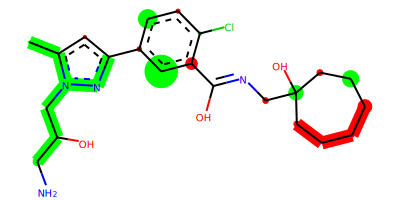

In [7]:
from molexplain.vis import molecule_importance
molecule_importance(mol, model, task=0, vis_factor=5)